In [274]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium as fm
import numpy as np
from math import radians, cos, sin, asin, sqrt
from copy import deepcopy 
from scipy.stats import norm, kurtosis
import random

In [295]:
df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
dists = np.load('dists.npy')
data = [df,dists]

def Fair(distribution, agegroups):
    #adapted the fairness formula to take into account that kids/adults/seniors
    #get different amounts of food by design
    allocations = {0:70, 1:56, 2:42} #0 is kids, 1 is adults, 2 is seniors. 
    if len(distribution) == 0:
        return 0
    
    totalsupply = sum(distribution)
    
    fairscore = 0
    for i in range(len(distribution)):
        recieved = distribution[i]/totalsupply
        allocated = allocations[agegroups[i]]/totalsupply
        fairscore += (recieved-allocated)**2
    
    fairscore = 1/(len(distribution)*fairscore+1)

    return fairscore

def returndata(data):
    df = data[0]
    dists = data[1]
    
    stdevs = np.array((df['StDev(Demand per Visit)']))
    variance = stdevs**2
    stdevs = np.sqrt(np.matmul(variance,dists))
    demands = np.array((df['Average Demand per Visit']))
    increment = np.matmul(demands/(70/772*365), dists) 
    
    return demands, stdevs, increment

def runsite(site, data, RANDOM_DEMAND = True, SECOND_VISIT = False, FOOD = 0, LAST_VISIT = False):
    demands, stdevs, na = returndata(data) #gives the data we need    
    expdemand = demands[site] #expected demand for this site
    stdev = stdevs[site]      #standard deviation of demand at this site
    
    if RANDOM_DEMAND:
        demand = int(random.normalvariate(expdemand,stdev))#normally distributed random variable   
    else:
        demand = int(expdemand)
    
    daysoffood = 14 #how many days we expect the food to last everyone
    ages = np.array([.41,.4,.19]) #proportions of kids/adults/seniors
    fooddist = np.array([5,4,3]) #how many lbs of food kids/ad/sen eat each day
    evfood = np.dot(ages,fooddist*daysoffood) #expected value of food demanded by random person
    
    if SECOND_VISIT:
        LAST_VISIT = True
        totalfood = FOOD
    else:
        totalfood = min(15000,(expdemand+1.645*stdev)*evfood)
    #bring enough food so that you have >50 pounds per person 95% of the time
    
    ppl_food_quantity = []      # initialize array of X_i's for ppl's quanitity in lbs for 2 weeks
    agegroups = [] #age breakdown of crowd

    for i in range(0,demand):  # for each person at a site
        expleft = max(int(expdemand*(1-(i/demand))),1) #expected remaining people
        foodleft = totalfood-sum(ppl_food_quantity) #remaining food
        expfoodperperson = foodleft/expleft #expected remaining food/person
        
        ratio = 1 #default is don't change anything
        if LAST_VISIT: #if its the last visit of the day
            if expfoodperperson > evfood+10: #if we have a lot more food than we expect
                ratio = expfoodperperson/evfood #ratio>1                
        if expfoodperperson < evfood-10: #if we have a lot less food than we expect
            ratio = expfoodperperson/evfood #ratio < 1
        
        x = random.random()#random number to decide age of person
        if x<=ages[0]: #record their age group
                agegroups.append(0)
        elif x<=ages[0]+ages[1]:
            agegroups.append(1)
        else:
            agegroups.append(2)

        if sum(ppl_food_quantity)>totalfood: #if were out of food
            ppl_food_quantity.append(0) #you dont get any
        else:
            if x<=ages[0]:     # the person is a child
                ppl_food_quantity.append(min(100,max(35,fooddist[0]*daysoffood*ratio)))         # 5 lbs of food per day
                agegroups.append(0)
            elif x <= ages[0]+ages[1]:       # the person is an adult
                ppl_food_quantity.append(min(125,max(28,fooddist[1]*daysoffood*ratio)))         # 4lbs of food a day
                agegroups.append(1)
            else:                    # the person is a senior
                ppl_food_quantity.append(min(80,max(21,fooddist[2]*daysoffood*ratio)))       # 3lbs of food a day
                agegroups.append(2)
    # quantitative meansurement of fairness
    fairness_val = Fair(ppl_food_quantity, agegroups)

    if 0 not in ppl_food_quantity: #
        max_ppl_srvd = demand
    else:
        max_ppl_srvd = ppl_food_quantity.index(0)
        
    return fairness_val, max_ppl_srvd, sum(ppl_food_quantity)

In [280]:
#USE THIS CELL TO GENERATE THE SCHEDULES AND VALUES FOR THE PARETO FRONT
data = [df,dists]
demands,stdevs,increment = returndata(data)

schedules = [] 
demandDist = []
fairnesslevels = []

nvisits = np.zeros(70)

factorincrements = 50
maxfactor = 5
inc = maxfactor/factorincrements
factor = 0

while factor <= maxfactor:
    print(factor)
    schedule = [] #empty list for schedule
    demands = np.array((df['Average Demand per Visit']))
    daysElapsed = np.zeros(70)
    excessdemand = 0
    nsrvd = 0
    fairness = 0
    
    for day in range(365):
        
        fx = daysElapsed*factor
        demands = demands + fx

        a = deepcopy(demands)
        a = np.sort(a)

        first = a[-1]
        index1 = np.where(demands == first)
        second = a[-2]
        index2 = np.where(demands == second)

        demands = demands - fx
        
        fair1, maxsrvd1, pds1 = runsite(index1, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        fair2, maxsrvd2, pds2 = runsite(index2, data, RANDOM_DEMAND = False, LAST_VISIT = True)
        
        fairness += fair1*maxsrvd1 + fair2*maxsrvd2
        nsrvd += maxsrvd1 + maxsrvd2
        
        demands = (demands - min(254,pds1/59.08)*dists[index1])[0]
        demands = (demands - min(254,pds1/59.08)*dists[index2])[0]
        
        daysElapsed = daysElapsed+1
        daysElapsed[int(index1[0])] = 0
        daysElapsed[int(index2[0])] = 0

        schedule.append([int(index1[0]),int(index2[0])])
        nvisits[index1] += 1
        nvisits[index2] += 1

        demands = [0 if x<0 else x for x in demands]
        demands = demands + increment
        excessdemand += sum(demands)

    schedules.append(schedule)
    fairnesslevels.append(float(fairness/nsrvd))
    demandDist.append(excessdemand/365)
    
    factor += inc

print(demandDist)
print(fairnesslevels)

0
396
314
285
279
269
265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
314
181
181
176
176
173
177
170
168
148
153
166
146
160
265
149
285
180
138
138
279
269
261
126
156
148
396
259
235
251
144
232
122
112
314
230
122
220
213
197
200
210
213
180
202
156
192
200
181
265
166
77
396
177
176
285
75
160
181
176
72
153
279
269
168
259
146
173
261
170
251
66
148
148
230
69
396
235
138
58
314
232
210
220
138
56
200
285
213
144
61
122
202
149
181
180
279
153
396
259
126
265
200
181
269
213
192
176
251
197
230
122
160
261
112
146
166
156
285
210
396
314
148
232
50
200
279
213
220
176
259
168
173
177
170
235
202
138
122
39
396
230
251
181
269
138
181
285
210
261
153
72
265
200
176
192
279
149
314
259
396
200
146
126
213
213
232
77
148
148
230
220
197
160
251
75
285
180
166
202
396
269
210
235
261
181
200
279
259
181
168
173
138
170
176
112
144
61
230
153
396
314
176
265
285
213
138
66
251
177
146
192
58
232
210
220
148
200
279
269
259
396
200
202
261
69
213
156
149
122
230
126

148
251
61
166
168
181
197
232
259
314
230
220
160
200
396
138
170
181
279
213
177
192
32
72
235
285
149
202
261
210
269
213
30
138
396
176
153
251
200
265
176
259
173
230
144
146
58
156
148
279
314
235
232
181
23
396
220
285
39
213
112
181
126
210
122
168
261
269
166
197
200
251
259
202
192
138
160
396
230
200
66
0.30000000000000004
396
314
285
279
269
265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
314
181
181
176
176
173
177
170
168
148
153
166
146
160
149
265
285
180
138
138
279
269
261
126
156
148
396
259
235
251
144
122
232
112
230
122
314
220
213
197
200
210
213
180
202
200
192
156
265
77
181
75
166
396
177
176
285
72
181
160
176
153
279
66
269
168
259
146
173
261
170
69
251
148
230
58
148
235
396
56
314
138
210
138
61
144
200
232
213
220
285
149
202
180
126
50
279
181
259
213
396
200
265
192
181
197
269
176
251
230
122
261
156
153
112
144
166
146
210
160
314
39
396
148
285
168
176
177
200
213
279
259
173
232
235
220
170
122
202
230
138
138
251
396
181
269
18

285
396
213
269
220
126
265
180
153
149
200
200
181
230
138
181
197
232
160
314
210
176
173
77
396
177
279
251
138
261
56
176
166
202
259
285
192
75
156
146
24
269
213
170
148
168
230
396
72
235
200
213
112
220
122
269
210
39
181
279
314
24
251
265
232
181
153
285
259
61
396
126
261
148
200
176
176
138
149
34
230
202
160
213
235
197
173
24
138
33
146
192
200
279
396
58
210
269
148
177
166
285
251
220
122
34
259
314
181
69
170
168
144
66
230
213
232
181
261
396
180
265
153
50
213
176
202
156
279
77
31
200
112
285
210
200
126
269
138
251
259
75
396
176
146
235
192
149
160
138
230
173
220
148
314
200
0.6
396
314
285
279
269
265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
314
181
181
176
176
173
177
170
168
148
153
166
146
160
149
265
285
180
138
138
279
269
261
126
156
148
396
259
235
144
251
122
232
112
230
122
314
220
213
197
200
210
213
202
180
200
192
156
77
265
75
181
72
166
396
176
177
285
181
160
176
66
153
279
69
269
168
173
259
146
261
170
148
58
251
56
230
14

32
213
213
251
285
181
144
72
235
197
232
176
396
269
24
149
177
181
146
279
126
230
202
173
39
192
168
153
34
176
200
122
160
259
210
220
166
396
285
138
69
261
265
251
314
148
156
213
235
112
34
66
33
138
26
279
58
269
181
230
56
232
396
200
50
170
181
213
176
180
259
122
146
200
285
202
210
148
31
197
192
251
149
77
220
261
126
396
153
177
168
173
314
213
279
17
230
148
265
176
75
160
61
269
138
166
259
230
285
235
181
396
72
232
210
181
200
138
144
251
176
23
200
146
202
220
122
279
112
261
213
170
29
192
213
314
396
153
197
259
285
230
27
269
200
149
69
148
156
126
168
265
180
210
173
251
30
200
181
396
66
232
177
181
279
138
176
160
58
235
122
166
261
285
202
176
220
259
213
230
146
56
148
138
314
396
39
32
269
77
210
192
213
251
153
200
148
170
279
75
25
200
50
269
265
112
197
285
181
232
396
181
259
149
168
230
261
126
173
144
213
72
202
314
220
61
122
235
138
176
210
0.8999999999999999
396
314
285
279
269
265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
314


148
202
279
122
285
213
181
269
314
176
210
153
259
112
24
235
396
24
181
32
213
200
177
144
61
265
251
200
149
122
230
176
126
261
235
77
146
66
285
197
170
279
220
396
192
232
166
160
17
75
213
210
259
202
269
168
148
181
314
173
138
34
72
33
138
265
34
148
251
230
396
153
200
156
181
285
176
279
26
261
31
213
200
56
176
69
112
180
259
220
210
235
146
232
213
149
177
396
261
269
122
126
50
192
202
29
314
181
230
170
251
197
285
75
160
166
148
58
279
213
200
39
168
27
265
396
148
138
173
122
259
181
138
23
210
144
153
77
192
30
220
176
213
61
269
66
200
261
232
230
176
285
146
396
251
235
314
202
181
279
156
72
200
149
25
180
126
259
112
177
148
24
32
170
210
197
396
160
166
213
265
181
213
168
230
285
269
138
220
56
173
261
251
279
192
176
153
138
69
122
232
314
396
148
200
259
146
202
181
170
200
75
180
235
210
24
24
176
285
230
58
33
148
122
34
34
213
396
149
50
279
269
181
251
126
261
177
77
265
220
197
144
259
213
26
160
166
112
200
176
314
168
176
138
396
232
285
210
230
153
192

39
24
220
122
148
66
72
230
177
146
396
200
210
200
213
235
285
181
202
149
251
181
213
126
58
144
279
69
160
24
176
176
269
232
197
32
314
259
396
261
230
148
17
56
168
122
138
166
153
173
192
220
285
210
138
34
200
265
148
170
251
112
146
180
396
279
181
61
202
213
200
34
181
33
259
235
77
269
230
213
156
177
232
314
261
176
149
75
285
126
396
26
144
210
160
31
122
176
200
220
251
197
279
72
66
29
192
153
138
168
269
166
148
173
259
213
265
181
396
230
146
138
202
56
170
285
181
50
314
27
58
261
232
148
210
39
200
69
235
122
176
279
251
112
200
23
213
396
30
220
25
180
259
177
149
126
269
230
261
160
213
285
24
176
153
192
181
148
197
138
77
168
396
220
202
265
314
166
210
146
279
173
181
61
251
75
232
144
138
156
24
200
32
122
259
170
176
230
176
285
396
235
72
269
200
34
261
213
66
180
213
200
24
112
181
33
126
279
210
192
149
148
177
160
220
153
251
314
202
396
168
148
34
56
122
265
269
259
230
146
285
138
181
232
197
58
69
166
173
17
26
122
138
31
213
261
200
279
396
176
50
180
2

251
156
122
30
25
126
149
259
220
61
146
200
148
210
122
213
153
24
279
176
202
24
197
181
180
396
235
230
192
77
50
24
166
261
200
213
279
181
75
285
170
269
160
251
173
314
39
176
138
259
265
168
232
112
72
396
138
210
197
146
148
220
66
69
17
32
148
230
166
177
126
202
144
153
200
181
149
176
279
285
200
213
34
261
213
396
58
251
192
235
269
259
156
33
181
34
122
314
31
210
56
148
26
232
122
170
160
230
265
173
138
180
220
396
61
146
176
168
279
285
138
197
77
181
29
200
202
181
112
251
213
259
261
75
153
269
176
166
126
200
27
396
177
210
149
314
192
230
213
23
72
235
148
50
30
148
232
285
279
25
122
66
220
69
265
39
144
200
396
146
160
259
251
170
138
173
181
202
213
181
261
24
168
269
138
210
176
230
24
58
156
197
153
176
314
122
279
396
285
24
220
122
265
192
200
126
166
112
180
232
56
32
213
259
235
148
149
251
200
168
77
220
177
72
61
213
34
396
146
261
230
210
181
269
181
202
75
285
279
160
144
138
33
173
170
34
31
314
213
148
265
26
17
138
153
176
259
396
176
156
197
251
66


269
259
265
72
146
148
197
177
232
153
210
220
29
251
148
112
144
66
69
180
27
285
261
235
30
58
23
176
138
173
149
396
181
56
314
160
279
168
230
202
122
176
181
200
25
126
170
259
138
213
61
24
269
24
156
210
192
24
213
251
146
285
396
314
200
148
265
232
122
220
166
50
153
269
261
197
39
279
17
230
177
77
181
235
176
259
75
213
200
138
112
396
202
173
72
213
181
144
149
210
180
285
32
251
160
168
148
156
34
314
176
138
170
126
66
153
192
69
146
230
34
396
279
261
33
269
232
148
220
26
58
259
265
200
31
181
122
200
56
166
176
285
197
213
210
202
235
251
29
181
61
396
213
177
138
122
314
173
27
230
279
30
23
149
112
160
168
146
269
261
156
192
259
138
77
176
170
153
232
126
75
285
396
220
200
148
181
210
180
72
50
251
265
213
25
144
39
148
176
314
202
200
230
279
24
181
24
166
66
58
235
396
197
259
24
269
69
213
138
261
285
173
122
146
177
32
200
232
192
210
168
160
149
251
56
153
220
138
181
34
112
396
230
213
148
279
170
176
122
17
126
314
235
265
202
200
259
176
34
285
61
181
156
2

39
261
213
166
156
279
251
176
220
160
173
32
168
122
170
192
177
230
34
235
138
33
34
202
26
396
181
269
138
210
259
31
181
265
285
232
29
149
77
200
72
314
126
213
176
148
279
200
75
251
213
261
146
180
27
197
396
148
168
230
69
153
220
66
112
30
23
25
24
181
58
166
259
285
192
210
173
269
160
176
56
202
181
61
122
170
235
396
138
144
156
279
200
24
24
232
177
138
251
314
265
213
17
230
176
261
122
50
149
213
146
126
200
39
148
259
285
220
396
210
168
153
197
269
77
181
180
72
32
112
148
279
192
181
75
202
200
166
34
251
173
34
160
33
230
235
176
396
26
213
232
314
138
148
170
261
285
69
122
259
66
265
176
149
138
210
31
146
58
230
156
177
220
29
279
269
213
200
396
126
56
181
144
153
200
251
61
181
168
160
27
202
192
197
279
122
213
285
30
314
23
259
232
166
173
261
112
235
396
25
24
210
230
180
148
176
138
77
148
72
50
176
170
265
220
269
75
146
39
138
122
200
251
149
24
24
279
396
285
181
181
213
200
259
153
213
177
202
126
32
17
314
192
230
69
279
261
210
168
232
66
160
156
197
5

138
149
58
61
180
396
56
279
176
126
259
144
251
230
181
181
269
213
200
192
148
122
197
112
210
261
50
213
39
314
146
153
148
200
265
396
180
285
166
156
170
176
32
173
235
160
122
232
202
279
168
220
259
33
34
251
230
138
177
34
138
26
31
269
176
396
181
210
77
149
29
181
72
27
261
213
23
126
75
285
192
200
314
213
200
30
69
197
146
25
279
148
66
259
24
265
153
396
180
230
251
58
24
261
232
112
202
220
61
166
235
170
24
56
279
138
144
173
269
210
176
160
148
122
168
181
285
176
17
138
156
213
396
181
200
177
122
279
314
50
259
149
39
230
192
146
251
126
148
200
213
261
32
77
202
153
197
265
232
72
220
396
75
269
69
210
180
259
285
33
235
34
34
166
170
181
31
279
138
213
200
26
173
112
66
176
230
168
314
160
176
251
181
396
138
58
29
202
27
23
261
220
192
146
148
61
156
235
177
285
149
259
210
122
56
148
232
269
144
200
153
213
265
126
279
30
122
396
173
261
197
200
230
181
213
25
24
251
24
314
170
166
138
77
176
24
50
72
181
180
75
285
39
202
168
259
220
160
69
396
210
176
138
148
14

24
192
181
181
122
259
176
17
269
251
230
153
261
396
166
146
77
176
156
177
75
160
148
173
314
210
168
170
72
69
66
148
58
269
138
235
213
200
285
232
220
112
138
61
56
149
180
279
396
202
265
259
126
230
144
181
251
213
200
181
50
192
261
176
197
39
122
314
210
153
146
32
148
269
166
285
34
396
34
33
213
156
122
176
160
200
173
279
31
168
177
232
170
220
259
148
26
230
138
235
251
180
202
138
29
77
112
23
181
396
27
265
75
261
210
213
148
149
181
285
72
126
314
30
176
192
269
200
213
66
25
69
146
58
24
279
153
200
197
24
259
24
122
181
396
230
166
251
61
56
232
144
220
17
160
173
176
168
202
259
170
210
176
285
235
138
261
177
213
156
50
314
138
122
265
181
269
148
396
180
39
279
148
112
146
32
200
149
192
232
230
160
126
213
77
200
34
251
122
153
181
34
33
75
259
31
72
285
220
197
210
396
26
166
202
261
200
213
66
314
29
176
173
279
69
269
265
168
176
170
58
235
138
181
23
230
27
148
138
177
259
146
251
396
56
232
144
61
30
192
285
25
156
181
180
210
149
122
213
160
200
126
112
153


138
34
144
210
31
26
148
232
29
220
213
396
126
200
27
122
23
181
30
112
25
285
202
24
24
213
265
200
24
197
279
192
181
180
17
122
176
259
269
251
230
166
153
261
77
146
176
396
148
160
75
177
173
168
72
314
210
156
69
170
66
144
148
138
58
213
235
56
200
285
61
232
138
220
149
279
181
202
126
396
50
265
259
230
251
181
269
122
39
213
180
200
176
192
112
261
197
32
153
210
146
200
148
314
33
34
166
34
31
285
396
176
213
160
173
122
26
279
168
156
148
144
29
177
259
170
232
230
138
220
235
251
181
77
202
27
23
269
138
181
75
72
30
396
153
265
149
210
25
261
126
200
176
66
69
285
24
24
192
213
166
314
200
146
58
148
24
279
213
56
197
259
180
61
17
230
112
122
396
251
232
173
160
202
176
50
220
168
269
181
39
138
170
235
192
210
181
156
177
285
122
261
200
148
138
144
153
396
265
32
176
279
314
149
33
197
259
126
77
213
34
230
34
146
31
220
148
251
213
75
200
166
26
72
232
29
269
202
396
66
285
69
210
181
173
180
160
176
27
181
200
112
176
192
168
261
279
58
23
138
235
259
170
30
56
314


181
166
177
50
176
396
265
285
153
160
173
168
279
261
170
146
269
148
156
259
39
251
32
34
148
230
33
149
34
235
314
138
138
213
31
210
26
144
29
232
27
220
23
396
126
30
25
200
24
24
24
202
213
17
200
285
197
112
176
181
279
192
181
122
180
176
122
269
265
259
261
251
77
230
166
153
148
177
75
146
148
396
173
72
160
168
314
156
210
170
66
213
69
58
56
61
200
235
232
138
138
220
200
285
149
50
279
144
176
202
126
181
259
396
39
213
180
230
251
269
181
261
197
192
176
200
32
265
34
33
112
314
148
210
34
279
153
160
148
146
166
213
31
26
122
173
285
396
177
122
29
200
168
156
232
27
170
259
220
77
23
235
30
230
25
251
75
138
138
202
181
24
24
269
72
261
149
24
176
181
126
279
66
396
210
213
17
176
314
69
192
200
58
285
180
265
56
213
61
197
144
112
148
153
146
259
200
170
160
166
230
232
50
122
251
173
220
148
168
396
39
177
176
181
269
202
235
156
261
279
32
210
138
138
122
34
192
285
181
314
33
34
77
149
176
126
31
75
213
213
259
26
396
230
200
265
200
251
29
148
72
146
27
153
180
396

112
251
235
122
232
230
220
314
213
210
200
197
77
75
213
72
202
66
69
200
192
58
56
61
181
180
176
181
50
177
166
176
396
265
285
153
160
173
168
279
170
261
251
39
146
269
148
259
156
32
34
33
34
31
230
148
149
138
138
26
314
235
210
29
27
144
200
23
232
30
220
25
396
126
213
24
24
24
112
17
202
213
200
177
285
197
181
122
279
192
181
180
122
176
251
265
269
259
261
77
153
75
166
230
176
72
173
69
146
160
396
168
148
66
170
156
314
210
58
144
61
56
200
235
138
138
50
232
149
213
220
285
148
279
202
39
126
181
251
259
213
396
177
200
269
181
230
32
261
192
112
180
176
197
265
33
34
31
34
144
153
26
210
232
314
122
146
166
29
173
148
176
200
160
396
285
122
168
279
27
156
213
170
30
23
77
259
25
251
75
220
235
138
138
72
230
202
181
24
269
24
69
24
149
144
66
261
17
181
126
213
396
192
200
210
58
176
61
56
177
180
265
173
314
285
232
148
197
200
279
153
269
146
112
230
148
259
50
213
166
251
39
176
160
168
396
122
220
149
170
32
156
181
77
202
235
138
138
33
122
261
34
144
210
31
34
26

168
148
153
166
146
160
149
180
138
138
285
265
279
269
126
156
148
261
144
259
396
122
112
251
235
122
232
230
220
314
213
77
210
200
75
72
213
197
66
69
202
200
58
192
61
56
181
180
176
181
50
177
166
176
39
396
285
265
153
160
173
168
279
170
261
146
251
269
148
156
259
32
34
34
33
31
396
230
149
148
26
29
138
138
314
235
27
23
210
30
25
144
232
24
220
24
126
192
213
24
200
112
17
213
202
200
285
177
197
122
181
181
180
122
396
279
176
265
251
77
259
261
269
75
72
166
230
153
176
69
66
146
160
173
148
58
168
170
156
314
61
56
210
144
213
235
50
149
192
138
396
138
232
213
285
220
200
39
148
279
202
126
181
32
251
259
181
200
180
177
230
265
261
34
269
176
112
197
34
33
31
166
146
314
396
26
29
153
122
210
27
122
148
23
30
176
173
160
285
213
77
25
168
170
279
213
156
149
75
24
200
24
232
235
259
192
220
72
251
144
138
230
138
396
202
181
24
69
66
17
269
261
166
314
181
58
126
153
56
265
200
61
176
210
177
148
197
146
285
180
176
50
112
279
396
148
39
213
122
259
200
173
213
160
32
2

232
235
210
220
213
396
200
213
202
200
192
197
181
314
181
176
176
173
177
170
168
148
153
166
146
160
149
180
138
138
285
265
279
126
269
156
148
261
144
259
396
122
112
251
235
122
232
230
220
314
213
77
210
75
200
72
213
197
66
69
202
200
58
61
192
56
181
50
176
181
180
177
166
39
176
396
285
265
153
160
173
168
170
279
261
146
148
251
269
32
259
34
34
33
31
26
156
29
230
30
149
27
138
148
138
314
235
23
25
24
210
24
144
24
232
126
220
396
213
17
200
112
213
202
200
285
197
122
181
122
181
192
279
180
176
77
265
251
75
259
261
72
177
269
153
166
69
66
176
230
146
148
160
173
58
168
396
61
170
314
56
156
210
50
235
148
39
138
138
285
149
213
232
200
220
259
279
144
202
126
181
32
251
213
200
181
34
34
192
33
396
197
261
176
269
112
230
180
265
26
31
29
314
30
153
27
168
122
148
146
166
122
210
23
285
177
25
156
176
77
24
173
160
138
259
24
279
213
200
396
75
72
170
24
235
232
251
220
138
66
202
17
69
181
149
230
58
181
261
126
269
61
213
56
148
200
192
176
314
50
197
285
265
210
144

265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
181
314
181
176
176
173
177
170
168
148
153
166
146
160
149
180
138
138
285
265
279
126
269
156
148
261
144
259
122
396
112
251
122
235
232
230
220
77
314
75
213
210
72
200
213
197
66
69
202
58
200
61
56
192
181
50
176
181
396
180
177
39
166
176
153
285
160
265
173
168
170
279
146
261
148
251
32
269
259
34
34
33
235
31
26
29
27
156
230
30
149
23
138
138
25
148
24
24
314
200
24
210
396
126
232
144
220
17
122
213
192
112
200
122
269
213
202
285
197
181
181
279
176
265
261
180
77
75
251
210
259
72
153
69
66
166
176
177
146
160
148
230
173
396
168
156
235
58
170
56
148
61
314
50
39
200
213
269
138
138
149
285
232
220
200
192
279
32
126
34
202
181
122
144
265
261
396
251
259
210
181
213
34
33
176
31
112
26
197
29
230
180
166
27
30
122
153
23
200
146
314
25
156
148
24
24
235
176
160
285
269
213
148
177
173
77
396
75
279
168
24
72
200
170
220
17
232
69
66
138
138
251
259
181
210
192
261
202
149
58
265
230
126
56
181
61
176
21

251
200
149
29
75
4.999999999999998
396
314
285
279
269
265
259
261
251
230
232
235
210
220
213
396
200
213
202
200
192
197
181
314
181
176
176
173
177
170
168
148
153
166
146
160
149
180
138
138
285
265
279
126
269
156
148
261
144
259
122
112
396
251
122
235
232
230
220
77
75
314
72
213
210
200
213
66
69
197
202
58
200
61
56
192
50
181
181
176
39
177
180
166
176
173
160
153
285
265
396
168
170
279
32
148
261
146
34
269
34
33
259
314
31
26
235
29
251
27
23
30
230
25
149
156
138
138
24
213
24
148
24
126
144
232
210
197
220
17
213
122
192
112
181
122
396
200
269
177
202
200
285
181
279
148
176
77
180
75
72
265
314
213
259
69
261
153
166
173
66
176
160
251
146
58
168
235
230
170
56
61
148
50
126
396
39
156
210
232
197
269
138
138
149
213
220
32
285
200
144
192
265
279
181
34
314
34
202
177
181
213
33
259
148
31
26
200
396
176
112
30
29
180
261
251
122
27
23
176
230
122
153
25
235
24
173
146
166
24
210
24
148
160
77
259
75
156
269
168
285
72
170
232
213
279
200
17
69
126
396
220
265
314
66

In [281]:
freqList = []
for level in schedules:
    freq = [0] * 70
    for day in level:
        freq[day[0]] += 1
        freq[day[1]] += 1
    freqList.append(freq)

In [282]:
def gini(list):
    ## first sort
    arr = np.array(list)
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

def identify_pareto(scores):
    # Count number of items
    population_size = scores.shape[0]
    # Create a NumPy index for scores on the pareto front (zero indexed)
    population_ids = np.arange(population_size)
    # Create a starting list of items on the Pareto front
    # All items start off as being labelled as on the Parteo front
    pareto_front = np.ones(population_size, dtype=bool)
    # Loop through each item. This will then be compared with all other items
    for i in range(population_size):
        # Loop through all other items
        for j in range(population_size):
            # Check if our 'i' pint is dominated by our 'j' point
            if all(scores[j] < scores[i]) and any(scores[j] <= scores[i]):
                # j dominates i. Label 'i' point as not on Pareto front
                pareto_front[i] = 0
                # Stop further comparisons with 'i' (no more comparisons needed)
                break
    # Return ids of scenarios on pareto front
    return population_ids[pareto_front]

def lorenz_curve(freq):
    X = np.array(freq)
    X_lorenz = X.cumsum() / X.sum()
    X_lorenz = np.insert(X_lorenz, 0, 0) 
    X_lorenz[0], X_lorenz[-1]
    fig, ax = plt.subplots(figsize=[6,6])
    ## scatter plot of Lorenz curve
    ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, 
               marker='x', color='darkgreen', s=100)
    ## line plot of equality
    ax.plot([0,1], [0,1], color='k')

In [283]:
freqList[0].sort()

<IPython.core.display.Javascript object>


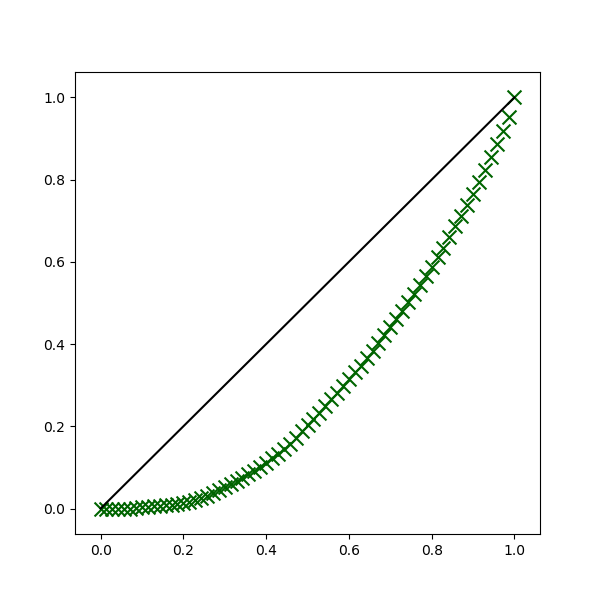

In [284]:
lorenz_curve(freqList[0])

In [285]:
unfairness = [1 - i for i in fairnesslevels] #minimize unfairness = maximize fairness
giniList = []
for i in freqList:
    giniList.append(gini(i))
minimize = np.column_stack((demandDist, giniList, unfairness))

<IPython.core.display.Javascript object>


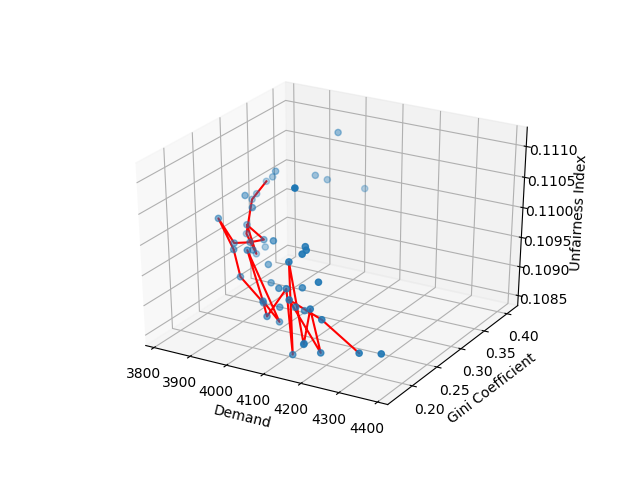

In [286]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
pareto = identify_pareto(minimize)
pareto_front = minimize[pareto]
x_all = minimize[:, 0]
y_all = minimize[:, 1]
z_all = minimize[:, 2]
x_pareto = pareto_front[:, 0]
y_pareto = pareto_front[:, 1]
z_pareto = pareto_front[:, 2]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_all, y_all, z_all)
ax.plot(x_pareto, y_pareto, z_pareto, color='r')
ax.set_xlabel('Demand')
ax.set_ylabel('Gini Coefficient')
ax.set_zlabel('Unfairness Index')
plt.show()

In [287]:
#RUN THIS CELL TO GENERATE THE BEST SCHEDULE
unfairness = 1 - np.array(fairnesslevels)

scaleddemand = (demandDist-min(demandDist))/(max(demandDist)-min(demandDist))
scaledfairness = (max(unfairness) - unfairness)/(max(unfairness)-min(unfairness))
scaledgini = (giniList-min(giniList))/(max(giniList)-min(giniList))

weightedarray = .5*scaleddemand+.3*scaledfairness+.2*scaledgini
ideal = np.where(weightedarray == min(weightedarray))[0][0]
idealfactor = ideal*inc

bestschedule = schedules[ideal]
#print(bestschedule) #our proposed 365 day schedule
totaldemand = demandDist[ideal]
ourfairness = fairnesslevels[ideal]
ginicoeff = giniList[ideal]

print(totaldemand,ourfairness,ginicoeff)

3835.0847593049616 0.8900293878512778 0.25311154598825825


In [288]:
def testschedule(schedule):
    
    df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
    dists = np.load('dists.npy')
    data = [df,dists]
    
    demands, stdevs, increment = returndata(data)
    ntrials = 2
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    for i in range(ntrials):
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0]
            site2 = day[1]
            
            fair1, nsrvd1, lbs1 = runsite(index1, data, LAST_VISIT = True)
            fair2, nsrvd2, lbs2 = runsite(index2, data, LAST_VISIT = True)            
            
            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
        
            demands = [0 if x<0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Gini Coefficient: ', Gini_Coefficient)
    print('Total Food Distributed: ', Total_Food)
    
    return [Average_Demand, Average_Fairness, Gini_Coefficient]

In [289]:
foodMap = fm.Map(location=[42.3, -76.5], tiles='Stamen Toner', zoom_start = 9.2)
coordinates = df[['latitude', 'longitude']]
coordinateList = coordinates.values.tolist()
#print(coordinateList)
for element in coordinateList:
    fm.CircleMarker(element, radius=3, color='blue', opacity=0.3).add_to(foodMap)
foodMap

In [290]:
def con_max(priorities, demand, leftover):
    index = -1
    for i in range(len(priorities)):
        if priorities[i] > priorities[index] and demand[i] <= leftover:
            index = i
    return index

In [291]:
def locate_min(a):
    smallest = min(a) #returns indices of all elements in list equal to the minimum element
    return [index for index, element in enumerate(a) if smallest == element]  
def locate_max(a):
    biggest = max(a)
    return [index for index, element in enumerate(a) if biggest == element]

In [292]:
countList = []
for year in schedules:
    freq = [0] * 70
    for day in year:
        freq[day[0]] += 1
        freq[day[1]] += 1
    countList.append(freq)
    
nSchedule = []
na, stdevs, na = returndata([df,dists])
avgDemands = df['Average Demand per Visit']

for day in schedules[ideal]: #run the best schedule block to get ideal
    daily = []
    for site in day:
        totalfood = min(15000, (avgDemands[site] + 1.645*stdevs[site])*59.08)
        leftover = (totalfood - (avgDemands[site]*59.08))

        if leftover >= (min(avgDemands)+1.645*stdevs[list(avgDemands).index(min(avgDemands))])*59.08: #95% threshold
            rare = locate_min(countList[ideal])
            rare_demand = []
            
            for i in rare:
                rare_demand.append(avgDemands[i])
            second = locate_max(rare_demand)
            visit = avgDemands[avgDemands == rare_demand[second[0]]]

            index = int(visit.index.tolist()[0])
            daily.append([site, index])
            countList[ideal][index] += 1
        
        else:
            daily.append([site, -1])
    nSchedule.append(daily)
nSchedule

[[[65, -1], [1, -1]],
 [[16, -1], [2, -1]],
 [[27, -1], [31, -1]],
 [[61, -1], [12, -1]],
 [[10, -1], [29, -1]],
 [[21, -1], [30, -1]],
 [[5, -1], [28, -1]],
 [[4, -1], [65, -1]],
 [[0, 35], [64, -1]],
 [[67, 38], [68, 48]],
 [[63, 45], [9, 54]],
 [[33, 59], [1, -1]],
 [[20, -1], [25, 60]],
 [[69, 50], [17, 58]],
 [[8, 40], [3, 47]],
 [[7, 37], [32, 35]],
 [[13, -1], [22, 44]],
 [[18, -1], [14, 55]],
 [[23, 49], [66, -1]],
 [[16, -1], [11, 38]],
 [[31, -1], [34, -1]],
 [[2, -1], [27, -1]],
 [[19, 48], [12, -1]],
 [[15, 45], [62, 54]],
 [[61, -1], [65, -1]],
 [[26, 59], [30, -1]],
 [[10, -1], [24, -1]],
 [[39, -1], [6, 60]],
 [[21, -1], [29, -1]],
 [[1, -1], [28, -1]],
 [[64, -1], [9, 53]],
 [[68, 43], [5, -1]],
 [[4, -1], [42, -1]],
 [[67, 50], [41, 58]],
 [[0, 40], [56, -1]],
 [[63, 47], [66, -1]],
 [[36, -1], [57, -1]],
 [[20, -1], [52, -1]],
 [[25, 37], [51, -1]],
 [[33, 35], [22, 44]],
 [[65, -1], [8, 55]],
 [[16, -1], [31, -1]],
 [[12, -1], [46, -1]],
 [[69, 49], [13, -1]],
 [[14,

In [296]:
def testschedule2(schedule):
    
    df = pd.read_csv('sites.csv') #read the data from the csv as a pandas dataframe
    dists = np.load('dists.npy')
    data = [df,dists]
    
    demands, stdevs, increment = returndata(data)
    ntrials = 2
    
    avgfairness = np.zeros(ntrials)
    avgdemand = np.zeros(ntrials)
    ginicoeff = np.zeros(ntrials)
    totalfood = np.zeros(ntrials)
    
    for i in range(ntrials):
        
        nsrvd = 0
        fairness = 0
        excessdemand = 0
        totallbs = 0
        nvisits = np.zeros(70)
        for day in schedule:    
            site1 = day[0][0]
            site12 = day[0][1]
            site2 = day[1][0]
            site22 = day[1][1]
            
            if site12 != -1:
                fair1, nsrvd1, lbs1 = runsite(site1, data, LAST_VISIT = True)
            else:
                fair1, nsrvd1, lbs1 = runsite(site2, data)
            if site22 != -1:
                fair2, nsrvd2, lbs2 = runsite(site2, data, LAST_VISIT = True)
            else:
                fair2, nsrvd2, lbs2 = runsite(site2, data)

            fairness += fair1*nsrvd1 + fair2*nsrvd2
            nsrvd += nsrvd1 + nsrvd2
            
            demands = (demands - min(254, lbs1/59.08)*dists[site1])
            demands = (demands - min(254, lbs2/59.08)*dists[site2])
            
            #print(demands)
            nvisits[site1] += 1
            nvisits[site2] += 1
            
            if site12 != -1:
                remainingfood = min(15000, (demands[site1] + 1.645*stdevs[site1])*59.08)-demands[site1]
                if remainingfood <0:
                    remainingfood = 0
                fair12, nsrvd12, lbs12 = runsite(site12, data, SECOND_VISIT = True, FOOD = remainingfood - demands[site1])
                fairness += fair12*nsrvd12
                nsrvd += nsrvd12
                demands = (demands - min(254, lbs12/59.08)*dists[site12])
                nvisits[site12] += 1
                totallbs += lbs12
            
            if site22 != -1:
                remainingfood = min(15000, (demands[site2] + 1.645*stdevs[site2])*59.08) - demands[site2]
                if remainingfood <0:
                    remainingfood = 0
                fair22, nsrvd22, lbs22 = runsite(site22, data, SECOND_VISIT = True, FOOD = remainingfood - demands[site2])
                fairness += fair22*nsrvd22
                nsrvd += nsrvd22
                demands = (demands - min(254, lbs22/59.08)*dists[site22])
                nvisits[site22] += 1
                totallbs += lbs22
        
            demands = [0 if x<0 else x for x in demands]
            demands = demands + increment
            excessdemand += sum(demands)
            totallbs += lbs1+lbs2
            
        nvisits.sort()
        
        avgdemand[i] = excessdemand/365
        avgfairness[i] = fairness/nsrvd
        ginicoeff[i] = gini(nvisits)
        totalfood[i] = totallbs
    
    Average_Demand = np.mean(avgdemand)
    Average_Fairness = np.mean(avgfairness)
    Total_Food = np.mean(totallbs)
    Gini_Coefficient = gini(nvisits)

    print('Average Demand: ', Average_Demand)
    print('Average Fairness: ', Average_Fairness)
    print('Total Food Distributed: ', Total_Food)
    print('Gini Coefficient: ', Gini_Coefficient)
    
    return [Average_Demand, Average_Fairness, Total_Food, Gini_Coefficient]


In [297]:
testschedule2(nSchedule)

Average Demand:  6943.106662902452
Average Fairness:  0.8639433554203418
Total Food Distributed:  7712377.147769734
Gini Coefficient:  0.05929510327892529


[6943.106662902452, 0.8639433554203418, 7712377.147769734, 0.05929510327892529]

In [252]:
mySched = np.array(nSchedule)
mySched = mySched.flatten()
nvisits = sum([1 for x in mySched if x != -1])
nvisits

993

In [298]:
testschedule(schedules[ideal])

Average Demand:  3397.070917544078
Average Fairness:  0.8748671286940848
Gini Coefficient:  0.25311154598825825
Total Food Distributed:  10567425.56455168


[3397.070917544078, 0.8748671286940848, 0.25311154598825825]